In [ ]:
print("Hello world")

Hello world


# BAIT 508 Group Project: Industry Analysis
### Group Members: Ruchir Attri, Gagandeep Singh, Hanyu Xia


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
import numpy as np

In [57]:
import nltk
import string
from nltk.corpus import stopwords

In [90]:
from collections import Counter

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [112]:
from wordcloud import WordCloud

## Part 1. Quantitative Analysis of the Industry Sector


### Part 1.A. Industry Sector Selection and Data Filtering:

#### 1. Choosing an Industry:

Step 1: Read the major_groups.csv file

In [ ]:
data = pd.read_csv('major_groups.csv',index_col=['major_group'])

There are total 83 groups to choose from

In [ ]:
data.shape

(83, 1)

Step 2: Read the public_firms.csv file

In [ ]:
df_all = pd.read_csv('public_firms.csv')

The first two digits of SIC code will give us the major group number

In [ ]:
def get_first_two_digits(sic_code):
  '''
  Parameter:
  sic_code: A four digit number
  Output: The first two digit of SIC code
  '''
  return int(str(sic_code)[:2])

df_all['major_groups'] = df_all['sic'].apply(get_first_two_digits)

df_all.head()

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa,major_groups
0,1004,1994,USA,AAR CORP,1988/01/01,5080,13.375,22.487,10.463,425.814,451.395,0.024572,50
1,1004,1995,USA,AAR CORP,1988/01/01,5080,22.000,33.606,16.012,437.846,504.990,0.036570,50
2,1004,1996,USA,AAR CORP,1988/01/01,5080,30.250,51.705,23.025,529.584,589.328,0.043478,50
3,1004,1997,USA,AAR CORP,1988/01/01,5080,38.750,17.222,35.657,670.559,782.123,0.053175,50
4,1004,1998,USA,AAR CORP,1988/01/01,5080,23.875,8.250,41.671,726.630,918.036,0.057348,50


In [ ]:
df_all.groupby(['major_groups'])['major_groups'].count()

major_groups
10    2908
12     435
13    7005
14     463
15     868
      ... 
83     253
86       5
87    3054
89       6
99    3321
Name: major_groups, Length: 68, dtype: int64

How many companies are in each group? Check by looking at a descending order of major group values

In [ ]:
group_strength = pd.DataFrame(df_all.groupby('major_groups').size(),columns=['count'])

Merge the data dataframe (which contains the major group names) and the group strength dataframe

In [ ]:
group_strength = pd.merge(data, group_strength, left_index=True, right_index=True)

In [ ]:
group_strength

,description,count
79,Amusement And Recreation Services,1989
56,Apparel And Accessory Stores,1367
23,Apparel And Other Finished Products Made From ...,1425
55,Automotive Dealers And Gasoline Service Stations,741
75,"Automotive Repair, Services, And Parking",355
...,...,...
37,Transportation Equipment,3772
47,Transportation Services,658
44,Water Transportation,1544
50,Wholesale Trade-durable Goods,3527


A look at the distribution of companies among major groups

In [ ]:
group_strength.describe()

,count
count,68.000000
mean,3076.647059
std,4816.533713
min,5.000000
25%,585.750000
50%,1368.500000
75%,3056.500000
max,24133.000000


In [ ]:
group_strength.sort_values(by=['count'], ascending=False).head(20)

,description,count
73,Business Services,24133
28,Chemicals And Allied Products,20351
60,Depository Institutions,19837
36,Electronic And Other Electrical Equipment And ...,12830
38,"Measuring, Analyzing, And Controlling Instrume...",10483
67,Holding And Other Investment Offices,9340
49,"Electric, Gas, And Sanitary Services",9066
35,Industrial And Commercial Machinery And Comput...,8618
48,Communications,7097
13,Oil And Gas Extraction,7005


* There are 68 major groups present in public firms data. [NOTE: The original major groups csv had 83 unique groups]
* There are, on an average, 3076 10-K reports in every group
* The Business Services	group (group 73) has the highest number of 10-K reports


We picked the **Miscellaneous Retail (group 59)**, which is the 16th largest in the major groups standing.

In [ ]:
group_number = 59

#### 2. Filtering companies for the selected major group

Step 1: Use the major group column in df_all to filter out companies

In [ ]:
df = df_all[df_all['major_groups'] == group_number]

Taking a look at the first 5 rows of the new filtered dataset to get an idea of the data

In [ ]:
df.head()

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa,major_groups
1902,1518,1995,USA,GALLERY OF HISTORY INC,NaN,5990,3.000,0.171,-0.041,11.547,2.233,-0.003551,59
1903,1518,1996,USA,GALLERY OF HISTORY INC,NaN,5990,2.875,0.116,-0.036,11.027,2.117,-0.003265,59
1904,1518,1997,USA,GALLERY OF HISTORY INC,NaN,5990,2.562,0.020,0.532,8.993,3.029,0.059157,59
1905,1518,1998,USA,GALLERY OF HISTORY INC,NaN,5990,18.750,0.015,0.076,8.780,2.818,0.008656,59
1906,1518,1999,USA,GALLERY OF HISTORY INC,NaN,5990,3.250,0.258,-0.183,9.251,2.317,-0.019782,59


#### 3. Answer the following questions based on the filtered dataset:

##### 3.a\) How many unique firm-year ("fyear") observations are there in the filtered dataset?

In [ ]:
unique_firm_years_count = len(df['fyear'].unique())
print(f"There are {unique_firm_years_count} years of financial data in the filtered dataset of Miscellaneous Retail companies")

There are 27 years of financial data in the filtered dataset of Miscellaneous Retail companies


##### 3.b\) How many unique firms are there in the filtered dataset?

In [ ]:
unique_firms_in_group_count = len(df['conm'].unique())
print(f"There are {unique_firms_in_group_count} unique retail companies")

There are 387 unique retail companies


##### 3.c\)	How many firms in the filtered dataset have records over all 27 years (1994-2020)?

In [ ]:
firms_with_full_records = df.groupby('conm').filter(lambda x: x['fyear'].nunique() == 27)
num_firms_with_full_records = firms_with_full_records['conm'].nunique()
print(f"There are {num_firms_with_full_records} retail companies with a full record of 27 years")

There are 7 retail companies with a full record of 27 years


In [ ]:
print("The firms are:")
_=1
for i in firms_with_full_records['conm'].unique():
  print(_,i)
  _+=1

The firms are:
1 MICHAELS COS INC
2 RITE AID CORP
3 SUNLINK HEALTH SYSTEMS INC
4 WILLIAMS-SONOMA INC
5 KASPIEN HOLDINGS INC
6 SIGNET JEWELERS LTD
7 IMEDIA BRANDS INC


### Part 1.B. Preliminary Analysis:

In [ ]:
#aesthetics
import warnings
warnings.filterwarnings("ignore")

#### 1.	What are the top 10 firms with the highest stock price (column "prcc_c") in the year 2020?

In [ ]:
print("The companies with the highest stock price in 2020 are:\n")
_=1
for i in df.sort_values('prcc_c', ascending=False)[df['fyear']==2020]['conm'].unique()[:10]:
  print(_,i)
  _+=1

The companies with the highest stock price in 2020 are:

1 AMAZON.COM INC
2 ULTA BEAUTY INC
3 CARVANA CO
4 WAYFAIR INC
5 DOORDASH INC
6 WILLIAMS-SONOMA INC
7 CHEWY INC
8 JD.COM INC
9 FIRSTCASH INC
10 CVS HEALTH CORP


#### 2. What are the top 10 firms with the highest sales (column "sale") in the entire history of the dataset?**bold text**

In [ ]:
print("The top 10 companies with the highest sales in the entire history of the dataset are:\n")
_=1
for i in df.sort_values('sale', ascending=False)['conm'].unique()[:10]:
  print(_,i)
  _+=1

The top 10 companies with the highest sales in the entire history of the dataset are:

1 AMAZON.COM INC
2 CVS HEALTH CORP
3 WALGREENS BOOTS ALLIANCE INC
4 JD.COM INC
5 EXPRESS SCRIPTS HOLDING CO
6 MEDCO HEALTH SOLUTIONS INC
7 CAREMARK RX INC
8 RITE AID CORP
9 NGL ENERGY PARTNERS LP
10 ODP CORP


#### 3.	What is the geographical distribution (column "location") of all the firms? In other words, how many firms are there in each location? Please list the top 10 locations.

How many firms are there in each location. List the top 10 locations

In [ ]:
unique_conms_each_location = df.groupby('location')['conm'].nunique()

In [ ]:
unique_conms_each_location_top_10 = unique_conms_each_location.sort_values(ascending=False)[:10]
for index, value in unique_conms_each_location_top_10.items():
  print(f"{index} has {value} retail companies")

USA has 337 retail companies
CHN has 24 retail companies
CAN has 4 retail companies
HKG has 3 retail companies
MYS has 2 retail companies
KOR has 2 retail companies
AUS has 2 retail companies
DEU has 2 retail companies
GBR has 1 retail companies
BMU has 1 retail companies


#### 4. Create a line chart to show the average stock price in the selected sector(s) across the years.

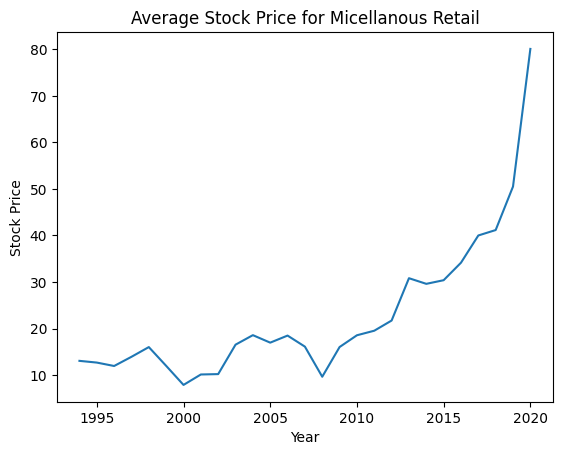

In [ ]:
plt.plot(df.groupby('fyear')['prcc_c'].mean())
plt.title('Average Stock Price for Micellanous Retail')
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.show()

#### 5. Which firm was affected the most by the 2008 Financial Crisis, as measured by the percentage drop in stock price from 2007 to 2008?

WIP

In [ ]:
df_crisis = df[np.logical_or(df['fyear'] == 2007,
                              df['fyear'] == 2008)]

In [ ]:
df_crisis.head()

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa,major_groups
1914,1518,2007,USA,GALLERY OF HISTORY INC,NaN,5990,1.0001,0.002,-0.390,8.874,0.632,-0.043949,59
1915,1518,2008,USA,GALLERY OF HISTORY INC,NaN,5990,1.0200,0.010,-0.522,8.782,0.520,-0.059440,59
14180,4523,2007,USA,JO-ANN STORES INC,NaN,5940,13.0800,25.400,15.400,869.400,1878.800,0.017713,59
14181,4523,2008,USA,JO-ANN STORES INC,NaN,5940,15.4900,80.600,21.900,901.100,1901.100,0.024304,59
23372,6802,2007,USA,LONGS DRUG STORES CORP,NaN,5912,47.0000,27.019,96.201,1846.716,5262.565,0.052093,59


In [ ]:
df_crisis.shape

(215, 13)

In [45]:
# Creating a pivot table with 'fyear' columns and 'conm' as index
pivot_df = df_crisis.pivot(index='conm', columns='fyear', values='prcc_c')

# Calculating the percentage change from 2007 to 2008
pivot_df['pct_change'] = ((pivot_df[2008] - pivot_df[2007]) / pivot_df[2007]) * 100

# Finding the company with the largest percentage drop
most_affected = pivot_df['pct_change'].idxmin()
largest_drop = pivot_df['pct_change'].min()

In [48]:
pivot_df.sort_values(by=['pct_change'])

fyear,2007,2008,pct_change
conm,,,
FINLAY ENTERPRISES INC,2.04,0.04,-98.039216
BORDERS GROUP INC,10.65,0.40,-96.244131
XPONENTIAL INC,0.82,0.04,-95.121951
IMEDIA BRANDS INC,6.29,0.33,-94.753577
SPORT CHALET INC,7.25,0.43,-94.068966
...,...,...,...
TOYS R US INC,NaN,NaN,NaN
VARSITY GROUP INC,0.21,NaN,NaN
VITACOST.COM INC,NaN,NaN,NaN


In [53]:
print(f"{most_affected} was the most affected, share price dropped by {round(largest_drop,2)}%")

FINLAY ENTERPRISES INC was the most affected, share price dropped by -98.04%


#### 6.	Plot the average Return on Assets (ROA) for the firms located in the “USA” across the years. ROA is calculated as ni/asset.

In [54]:
df.columns

Index(['gvkey', 'fyear', 'location', 'conm', 'ipodate', 'sic', 'prcc_c', 'ch',
       'ni', 'asset', 'sale', 'roa', 'major_groups'],
      dtype='object')

In [55]:
df.head()

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa,major_groups
1902,1518,1995,USA,GALLERY OF HISTORY INC,NaN,5990,3.000,0.171,-0.041,11.547,2.233,-0.003551,59
1903,1518,1996,USA,GALLERY OF HISTORY INC,NaN,5990,2.875,0.116,-0.036,11.027,2.117,-0.003265,59
1904,1518,1997,USA,GALLERY OF HISTORY INC,NaN,5990,2.562,0.020,0.532,8.993,3.029,0.059157,59
1905,1518,1998,USA,GALLERY OF HISTORY INC,NaN,5990,18.750,0.015,0.076,8.780,2.818,0.008656,59
1906,1518,1999,USA,GALLERY OF HISTORY INC,NaN,5990,3.250,0.258,-0.183,9.251,2.317,-0.019782,59


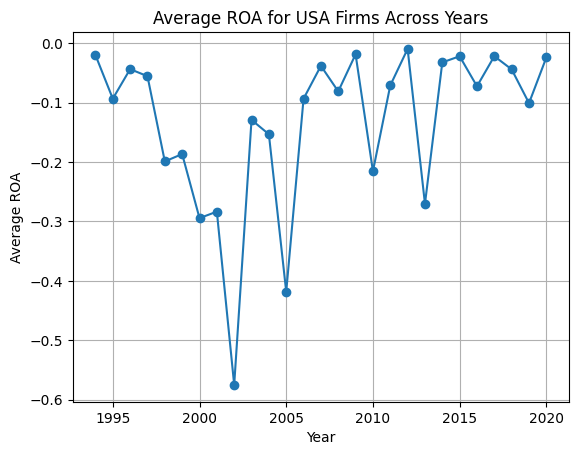

In [56]:
df['ROA'] = df['ni'] / df['asset']

# Filtering data for firms in the USA
usa_firms = df[df['location'] == 'USA']

# Grouping by year and calculating average ROA
avg_roa_per_year = usa_firms.groupby('fyear')['ROA'].mean()

# Plotting
plt.plot(avg_roa_per_year.index, avg_roa_per_year.values, marker='o')
plt.title('Average ROA for USA Firms Across Years')
plt.xlabel('Year')
plt.ylabel('Average ROA')
plt.grid(True)
plt.show()


## Part 2. Text Analysis on the Industry Sector

### C. Text Cleaning

In [58]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [59]:
df_10k = pd.read_csv('2020_10K_item1_full.csv')

In [ ]:
def text_preprocessing(txt: str):
  txt = txt.lower()
  puncs = string.punctuation
  translator = str.maketrans('', '', puncs)
  txt = txt.translate(translator)
  txt = txt.split()
  clean_words = []
  for w in txt:
      if w not in stopwords.words('english'):  # remove stopwords
          clean_words.append(w)
  clean_txt = ' '.join(clean_words)
  return clean_txt

skipping on cleaning all the text. O(N^2) complexity is taking too long.

In [74]:
# df_10k['conm'] = df_10k['name']
df_10k.rename(columns={'name':'conm'},inplace=True)
df_10k.rename(columns={'year':'fyear'},inplace=True)
df_10k.head()

,cik,fyear,conm,item_1_text
0,1041588,2020,ACCESS-POWER INC,fixed expenses are previosuly documented in an...
1,1693801,2020,"Luxxo, Inc.","Corporate History Luxxo, Inc., Formerly known ..."
2,1556179,2020,"RMR Industrials, Inc.",Overview RMR s predecessor entity was incorpor...
3,1626696,2020,STAR WEALTH GROUP INC.,Business Development & Business Overview We we...
4,315374,2020,HURCO COMPANIES INC,"General Hurco Companies, Inc. is an internatio..."


In [75]:
key_column = ["conm","fyear"]
df_retail = pd.merge(df_10k,df,on=key_column)

In [77]:
df_retail.shape

(7, 16)

NOTE: Not all companies in retail group have a 2020 10K report.

Cleaning the text for the companies in focus

In [81]:
df_retail['clean'] = df_retail['item_1_text'].apply(text_preprocessing)

In [85]:
def get_wordcount(text):
    return len(str(text).split())

In [88]:
def get_keywords_wc(text):
    c = Counter(text.split())
    words = []
    for pair in c.most_common(10):
        words.append(pair[0])
    return ' '.join(words)
    #return ' '.join([x[0] for x in c.most_common(10)])

In [87]:
def get_keywords_tfidf(document_list):
    '''
    Input: A list of documents (text)
    Output: The corresponding top 10 keywords for each document based on tf-idf values
    '''

    # Step 1: Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Step 2: Calculate the TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(document_list)

    # Step 3: Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()

    # Step 4: Extract top 10 keywords for each text
    top_keywords = []
    for i in range(len(document_list)):

        if i %100 == 0:
            print(f'Processing the {i}/{len(document_list)} document.')

        feature_index = tfidf_matrix[i, :].nonzero()[1]
        tfidf_scores = zip(feature_index, [tfidf_matrix[i, x] for x in feature_index])
        sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
        top_keywords.append(' '.join([feature_names[i] for i, _ in sorted_tfidf_scores[:10]]))

    return top_keywords

In [93]:
df_retail['keywords_wc'] = df_retail['clean'].apply(get_keywords_wc)

In [108]:
keywords = get_keywords_tfidf(df_retail.clean.tolist())

Processing the 0/7 document.


In [109]:
keywords

['solutions customers products sales product customer service business believe connection',
 'qvc programming qurate qxh fcc hsn us digital million television',
 'signet store jewelry fiscal jared diamond company stores customer kay',
 'cannabis company sct marijuana pure cbd harvest shares acquisition hsii',
 'pet medications pharmacy customer products care prescription customers 1800petmeds website',
 'medicare medicaid healthcare pharmacy services hospital reimbursement nursing care health',
 'sellers surplus buyers marketplaces assets buyer seller marketplace services salvage']

In [117]:
df_retail['keyword_tfidf'] =  keywords

In [121]:
df_retail.columns

Index(['cik', 'fyear', 'conm', 'item_1_text', 'gvkey', 'location', 'ipodate',
       'sic', 'prcc_c', 'ch', 'ni', 'asset', 'sale', 'roa', 'major_groups',
       'ROA', 'clean', 'word_count', 'keywords_wc', 'keyword_clean_tfidf',
       'keyword_tfidf'],
      dtype='object')

In [115]:
# prepare text
txt_wc = ' '.join(df_retail['keywords_wc'].tolist())

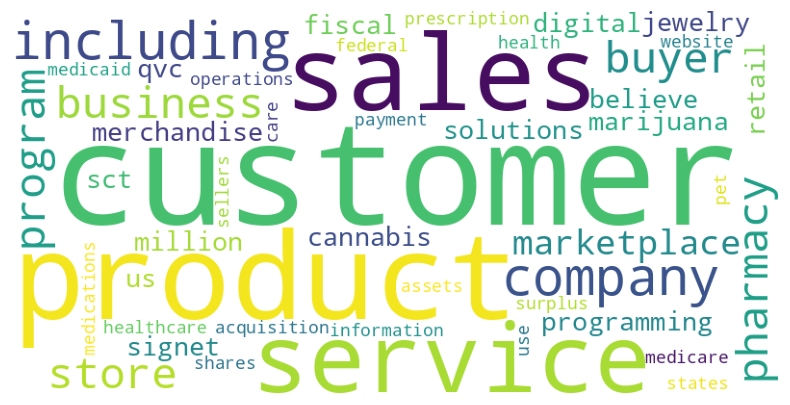

In [116]:
wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(txt_wc) # note that text is a string, not a list

plt.figure(figsize=(10,5))
plt.imshow(wordcloud1)
plt.savefig('keyword_wc.png') # save as PNG file
plt.axis('off')

plt.show()

In [125]:
txt_tfidf = ' '.join(df_retail['keyword_tfidf'].tolist())

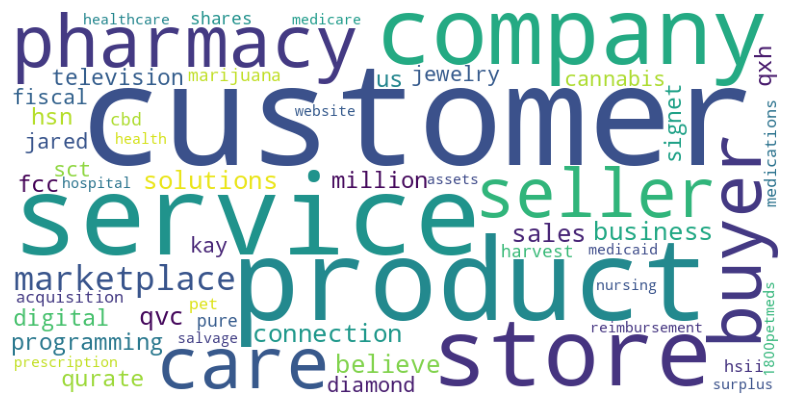

In [126]:
wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(txt_tfidf) # note that text is a string, not a list

plt.figure(figsize=(10,5))
plt.imshow(wordcloud2)
plt.savefig('keyword_tfidf.png') # save as PNG file
plt.axis('off')

plt.show()